In [1]:
# open a folder
import os
import cv2
import sys
import numpy as np
import pickle
from matplotlib import pyplot as plt
from keras.utils import np_utils
from ipywidgets import FloatProgress
from IPython.display import display
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

from sklearn.metrics import log_loss

from load_cifar10 import load_cifar10_data
from keras.applications.vgg16 import preprocess_input
from keras import backend as K


dir = '/home/elvis/data/comcars/general_part'
if not os.path.exists(dir):
    os.makedirs(dir)
part_name = {1:'headlight', 2:'taillight', 3:'fog light', 4:'air intake', 
             5:'console', 6: 'steering wheel', 7: 'dashboard', 8: 'gear lever', 9: 'none'}

# create folder for each part
#for key, name in part_name.items():
#    folder = dir + '/' + str(key)
#    if not os.path.exists(folder):
#        os.makedirs(folder)

/home/elvis/anaconda3/envs/tf_py3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def loadImage(fname_list, img_rows, img_cols, part_label, prefix='.', nb = sys.maxsize):
    """
    return a  numpy.ndadday with shape N,H,W,channel
    """
    print('loadImage for part ' + str(part_label+1)+ ' starts:')
    nb = min(len(fname_list), nb)
    f = FloatProgress(min=0, max=nb)
    display(f)
    
    X = np.empty([img_rows, img_cols, 3])
    Y = np.full([nb, 1], part_label)
    Initial_X = True
    for fname_idx, fname in enumerate(fname_list):
        img_fname = os.path.join(prefix, fname)
        im = cv2.resize(cv2.imread(img_fname), (img_rows,img_cols)).astype(float)
        im = np.expand_dims(im, axis=0)
        if Initial_X :
            X = np.array(im, dtype=float)
            Initial_X = False
        else:
            X = np.append(X, im, axis = 0)
        f.value += 1
        nb -=1
        if nb == 0:
            break
        
    print('loadImage finish:')
    print(X.shape)
    print(Y.shape)
    return X, Y

In [3]:
# load train/test the data for each part
train_test_split_dir = '/home/elvis/data/comcars/data/train_test_split/part/'
parts_train_fname = [None]*len(part_name)
parts_test_fname  = [None]*len(part_name)

for part_idx in range(len(part_name)):
    train_fname = os.path.join(train_test_split_dir, 'train_part_'+str(part_idx+1)+'.txt')
    test_fname  = os.path.join(train_test_split_dir, 'test_part_'+str(part_idx+1)+'.txt')
    with open(train_fname) as f:
        train_fname_list = f.read().splitlines()
        parts_train_fname[part_idx] = train_fname_list
    with open(test_fname) as f:
        test_fname_list = f.read().splitlines()
        parts_test_fname[part_idx] = test_fname_list

In [4]:
# load image
# goal: generate tuple of numpy arrays: `(x_train, y_train), (x_test, y_test)`.


image_dir_prefix = '/home/elvis/data/comcars/data/part'
img_rows, img_cols = 224, 224
train_nb = 1200
val_nb = 500


Initial = True
# load train part 1-8; none part doesn't load
for part_idx in range(len(parts_train_fname)-1):
    pickle_fname = 'car_part'+ str(part_idx+1) +'_train.pickle'
    if 'X' in locals(): del X
    if 'Y' in locals(): del Y
    if not os.path.isfile(pickle_fname) :
        print(pickle_fname +' loading')
        X, Y = loadImage(parts_train_fname[part_idx], img_rows, img_cols, part_idx, prefix=image_dir_prefix)
      
    else:
        print(pickle_fname +' existing, direcly loading')
        with open(pickle_fname, 'rb') as f:
            X = pickle.load(f)
            Y = np.full([X.shape[0], 1], part_idx)
        
    assert 'X' in locals() 
    assert 'Y' in locals() 
    print(X.shape)
    print(Y.shape)
    with open(pickle_fname, 'wb') as f:
        pickle.dump(X, f)
        pickle.dump(Y, f)
    X = X[0:min(train_nb, X.shape[0]),:]
    Y = Y[0:min(train_nb, Y.shape[0]),:]
    if Initial :
        X_train = X
        Y_train = Y
        Initial = False
    else:
        X_train = np.append(X_train, X, axis = 0)
        Y_train = np.append(Y_train, Y, axis = 0)
            

    
#with open('car_part_train.pickle', 'wb') as f:
#    pickle.dump(X_train, f)
#    pickle.dump(Y_train, f)   
# load test/val       

Initial = True     
for part_idx in range(len(parts_test_fname)-1):
    pickle_fname = 'car_part'+ str(part_idx+1) +'_test.pickle'
    if 'X' in locals(): del X
    if 'Y' in locals(): del Y
    if not os.path.isfile(pickle_fname) :
        print(pickle_fname + ' loading')
        X, Y = loadImage(parts_test_fname[part_idx], img_rows, img_cols, part_idx, prefix=image_dir_prefix)
    else:
        print(pickle_fname + ' existing, direcly loading')
        with open(pickle_fname, 'rb') as f:
            X = pickle.load(f)
            Y = np.full([X.shape[0], 1], part_idx)
           
    assert 'X' in locals() 
    assert 'Y' in locals()
    print(X.shape)
    print(Y.shape)
    with open(pickle_fname, 'wb') as f:
        pickle.dump(X, f)
        pickle.dump(Y, f)
    X = X[0:min(val_nb, X.shape[0]),:]
    Y = Y[0:min(val_nb, Y.shape[0]),:]
    if Initial:
        X_valid= X;
        Y_valid = Y;
        Initial = False
    else:
        X_valid = np.append(X_valid, X, axis = 0)
        Y_valid= np.append(Y_valid, Y, axis = 0)    

print('train_shape:')
print(X_train.shape)
print(Y_train.shape)
print('test_shape:')
print(X_valid.shape)
print(Y_valid.shape)
    
Y_train = np_utils.to_categorical(Y_train, 8)
Y_valid = np_utils.to_categorical(Y_valid, 8)
print('after normalizing Y:')
print(Y_train.shape)
print(Y_valid.shape)

     

car_part1_train.pickle existing, direcly loading
(1470, 224, 224, 3)
(1470, 1)
car_part2_train.pickle existing, direcly loading
(1419, 224, 224, 3)
(1419, 1)
car_part3_train.pickle existing, direcly loading
(1308, 224, 224, 3)
(1308, 1)
car_part4_train.pickle existing, direcly loading
(1374, 224, 224, 3)
(1374, 1)
car_part5_train.pickle existing, direcly loading
(1359, 224, 224, 3)
(1359, 1)
car_part6_train.pickle existing, direcly loading
(1382, 224, 224, 3)
(1382, 1)
car_part7_train.pickle existing, direcly loading
(1373, 224, 224, 3)
(1373, 1)
car_part8_train.pickle existing, direcly loading
(1374, 224, 224, 3)
(1374, 1)
car_part1_test.pickle existing, direcly loading
(1246, 224, 224, 3)
(1246, 1)
car_part2_test.pickle existing, direcly loading
(1191, 224, 224, 3)
(1191, 1)
car_part3_test.pickle existing, direcly loading
(1100, 224, 224, 3)
(1100, 1)
car_part4_test.pickle existing, direcly loading
(1146, 224, 224, 3)
(1146, 1)
car_part5_test.pickle existing, direcly loading
(1130, 2

In [5]:
def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):
    """VGG 16 Model for Keras

    Model Schema is based on 
    https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3

    ImageNet Pretrained Weights 
    https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing

    Parameters:
      img_rows, img_cols - resolution of inputs
      channel - 1 for grayscale, 3 for color 
      num_classes - number of categories for our classification task
    """
    model = Sequential()
    # 1
    model.add(ZeroPadding2D((1, 1), input_shape=(img_rows, img_cols, channel)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    # 2
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    #3
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    #4
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    #5
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Add Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    # Loads ImageNet pre-trained data
    model.load_weights('imagenet_models/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

    # Truncate and replace softmax layer for transfer learning
    model.layers.pop()
    model.outputs = [model.layers[-1].output]
    model.layers[-1].outbound_nodes = []
    model.add(Dense(num_classes, activation='softmax'))

    # Uncomment below to set the first 10 layers to non-trainable (weights will not be updated)
    #for layer in model.layers[:10]:
    #    layer.trainable = False

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

/home/elvis/anaconda3/envs/tf_py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/elvis/anaconda3/envs/tf_py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/elvis/anaconda3/envs/tf_py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/home/elvis/anaconda3/envs/tf_py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/home/elvis/anaconda3/envs/tf_py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/home/elvis/anaconda3/envs/tf_py3.5/lib/python3.5/si

Train on 9600 samples, validate on 4000 samples
Epoch 1/5
9600/9600 [==============================] - 151s 16ms/step - loss: 0.2089 - acc: 0.9429 - val_loss: 0.0701 - val_acc: 0.9842
Epoch 2/5
9600/9600 [==============================] - 147s 15ms/step - loss: 0.0547 - acc: 0.9872 - val_loss: 0.0471 - val_acc: 0.9932
Epoch 3/5
9600/9600 [==============================] - 147s 15ms/step - loss: 0.0240 - acc: 0.9943 - val_loss: 0.0564 - val_acc: 0.9900
Epoch 4/5
9600/9600 [==============================] - 149s 15ms/step - loss: 0.0109 - acc: 0.9982 - val_loss: 0.0448 - val_acc: 0.9950
Epoch 5/5
9600/9600 [==============================] - 148s 15ms/step - loss: 0.0052 - acc: 0.9989 - val_loss: 0.0508 - val_acc: 0.9940
dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


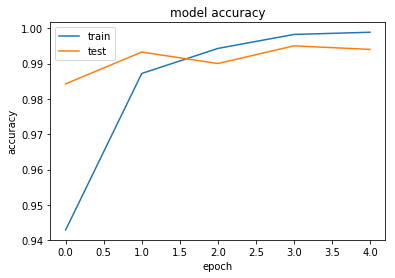

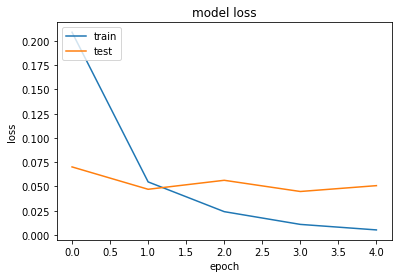

4000/4000 [==============================] - 18s 5ms/step


In [6]:
channel = 3
num_classes = 8 
batch_size = 16 
nb_epoch = 5

# Switch RGB to BGR order 
X_train = X_train[..., ::-1] 
X_valid = X_valid[..., ::-1]  
# Subtract ImageNet mean pixel 
X_train[:, :, :, 0] -= 103.939
X_train[:, :, :, 1] -= 116.779
X_train[:, :, :, 2] -= 123.68
X_valid[:, :, :, 0] -= 103.939
X_valid[:, :, :, 1] -= 116.779
X_valid[:, :, :, 2] -= 123.68

# Load our model
model = vgg16_model(img_rows, img_cols, channel, num_classes)

# Start Fine-tuning
history =model.fit(X_train, Y_train,
        batch_size=batch_size,
        epochs=nb_epoch,
        shuffle=True,
        validation_data=(X_valid, Y_valid),
)
# display performance
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
    
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Make predictions
predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

# Cross-entropy loss score
score = log_loss(Y_valid, predictions_valid)
model.save_weights('imagenet_models/car_part8.h5')
K.clear_session()

In [7]:
predictions_valid

array([[9.9999988e-01, 1.7806694e-07, 3.0079312e-09, ..., 3.3274261e-09,
        3.8121611e-10, 6.4423977e-09],
       [9.9996603e-01, 2.8738439e-05, 1.9520974e-06, ..., 4.3490152e-07,
        2.7950813e-07, 7.7100299e-07],
       [9.9999940e-01, 5.4179208e-07, 4.8076512e-08, ..., 5.8376735e-09,
        1.0033039e-09, 4.3036508e-09],
       ...,
       [2.8331721e-07, 4.3105960e-08, 1.2442273e-08, ..., 1.7051818e-08,
        7.3919799e-09, 9.9999964e-01],
       [3.9939457e-10, 1.6234174e-11, 1.6776382e-12, ..., 3.8132704e-12,
        2.7217516e-12, 1.0000000e+00],
       [2.6120706e-09, 2.5941554e-10, 7.0516187e-10, ..., 3.9443968e-10,
        2.2234362e-10, 1.0000000e+00]], dtype=float32)